In [46]:
# q_vis_response_plotter.ipynb
# Avery Krieger 05/23/2023

# Adapts code from uniform_flash.py to analyize and plot the AstA-->Chrimson, GCaMP
# vis responses

%load_ext autoreload
%autoreload 2

from visanalysis.analysis import imaging_data, shared_analysis
from visanalysis.util import plot_tools

from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter

import os
import numpy as np
from pathlib import Path

from scipy.interpolate import interp1d

# Load in flies
folder_path = "/Volumes/ABK2TBData/data_repo/bruker/20230519.selected"
exp_date = "2023-05-19"
folder_path1 = "/Volumes/ABK2TBData/data_repo/bruker/20230524.moco"
exp_date1 = "2023-05-24"

asta_fly1_prox = [folder_path, exp_date, "6", "medulla_terminals_all"]
asta_fly2_prox = [folder_path, exp_date, "9", "medulla_terminals_all"]
#asta_fly2_prox_comp1 = [folder_path, exp_date, "9", "medulla_terminals_comp8"]

asta_fly3_prox = [folder_path1, exp_date1, "1", "medulla_terminals"]
asta_fly4_prox = [folder_path1, exp_date1, "4", "medulla_terminals"]


asta_prox_all = [asta_fly1_prox, asta_fly2_prox, asta_fly3_prox, asta_fly4_prox]
asta_fly_list = [1, 2, 3, 4]

# Housekeeping:
condition_name = 'current_intensity'
save_directory = "/Volumes/ABK2TBData/lab_repo/analysis/outputs/q_vis_response/"
Path(save_directory).mkdir(exist_ok=True)


# Function that takes in a fly and outputs the trial data
def getTrialData(fly, return_more=False):
    file_path = os.path.join(fly[0], fly[1] + ".hdf5")
    ID = imaging_data.ImagingDataObject(file_path, fly[2], quiet=True)
    roi_data = ID.getRoiResponses(fly[3])
    time_vector = roi_data['time_vector']
    unique_parameter_values, mean_response, sem_response, trial_response_by_stimulus_intensity = ID.getTrialAverages(roi_data.get('epoch_response'), parameter_key=condition_name)

    if return_more:
        return unique_parameter_values, mean_response, sem_response, trial_response_by_stimulus_intensity, time_vector, ID
    
    else:
        return unique_parameter_values, mean_response, sem_response, trial_response_by_stimulus_intensity, time_vector

def visFlash(ID):
    flash_start = ID.getRunParameters('pre_time')
    flash_width = ID.getRunParameters('stim_time')
    flash_end = flash_start + flash_width
    
    return flash_start, flash_end

# create ID object and call visFlash
unique_parameter_values, _, _, _, _, ID = getTrialData(asta_fly1_prox, return_more=True)
flash_start, flash_end = visFlash(ID)

flash_types = ['Dark', 'Light']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Plot individual ROIs

unique_parameter_values: [[0.0], [1.0]]
unique_parameter_values: [[0.0], [1.0]]
unique_parameter_values: [[0.0], [1.0]]
unique_parameter_values: [[0.0], [1.0]]


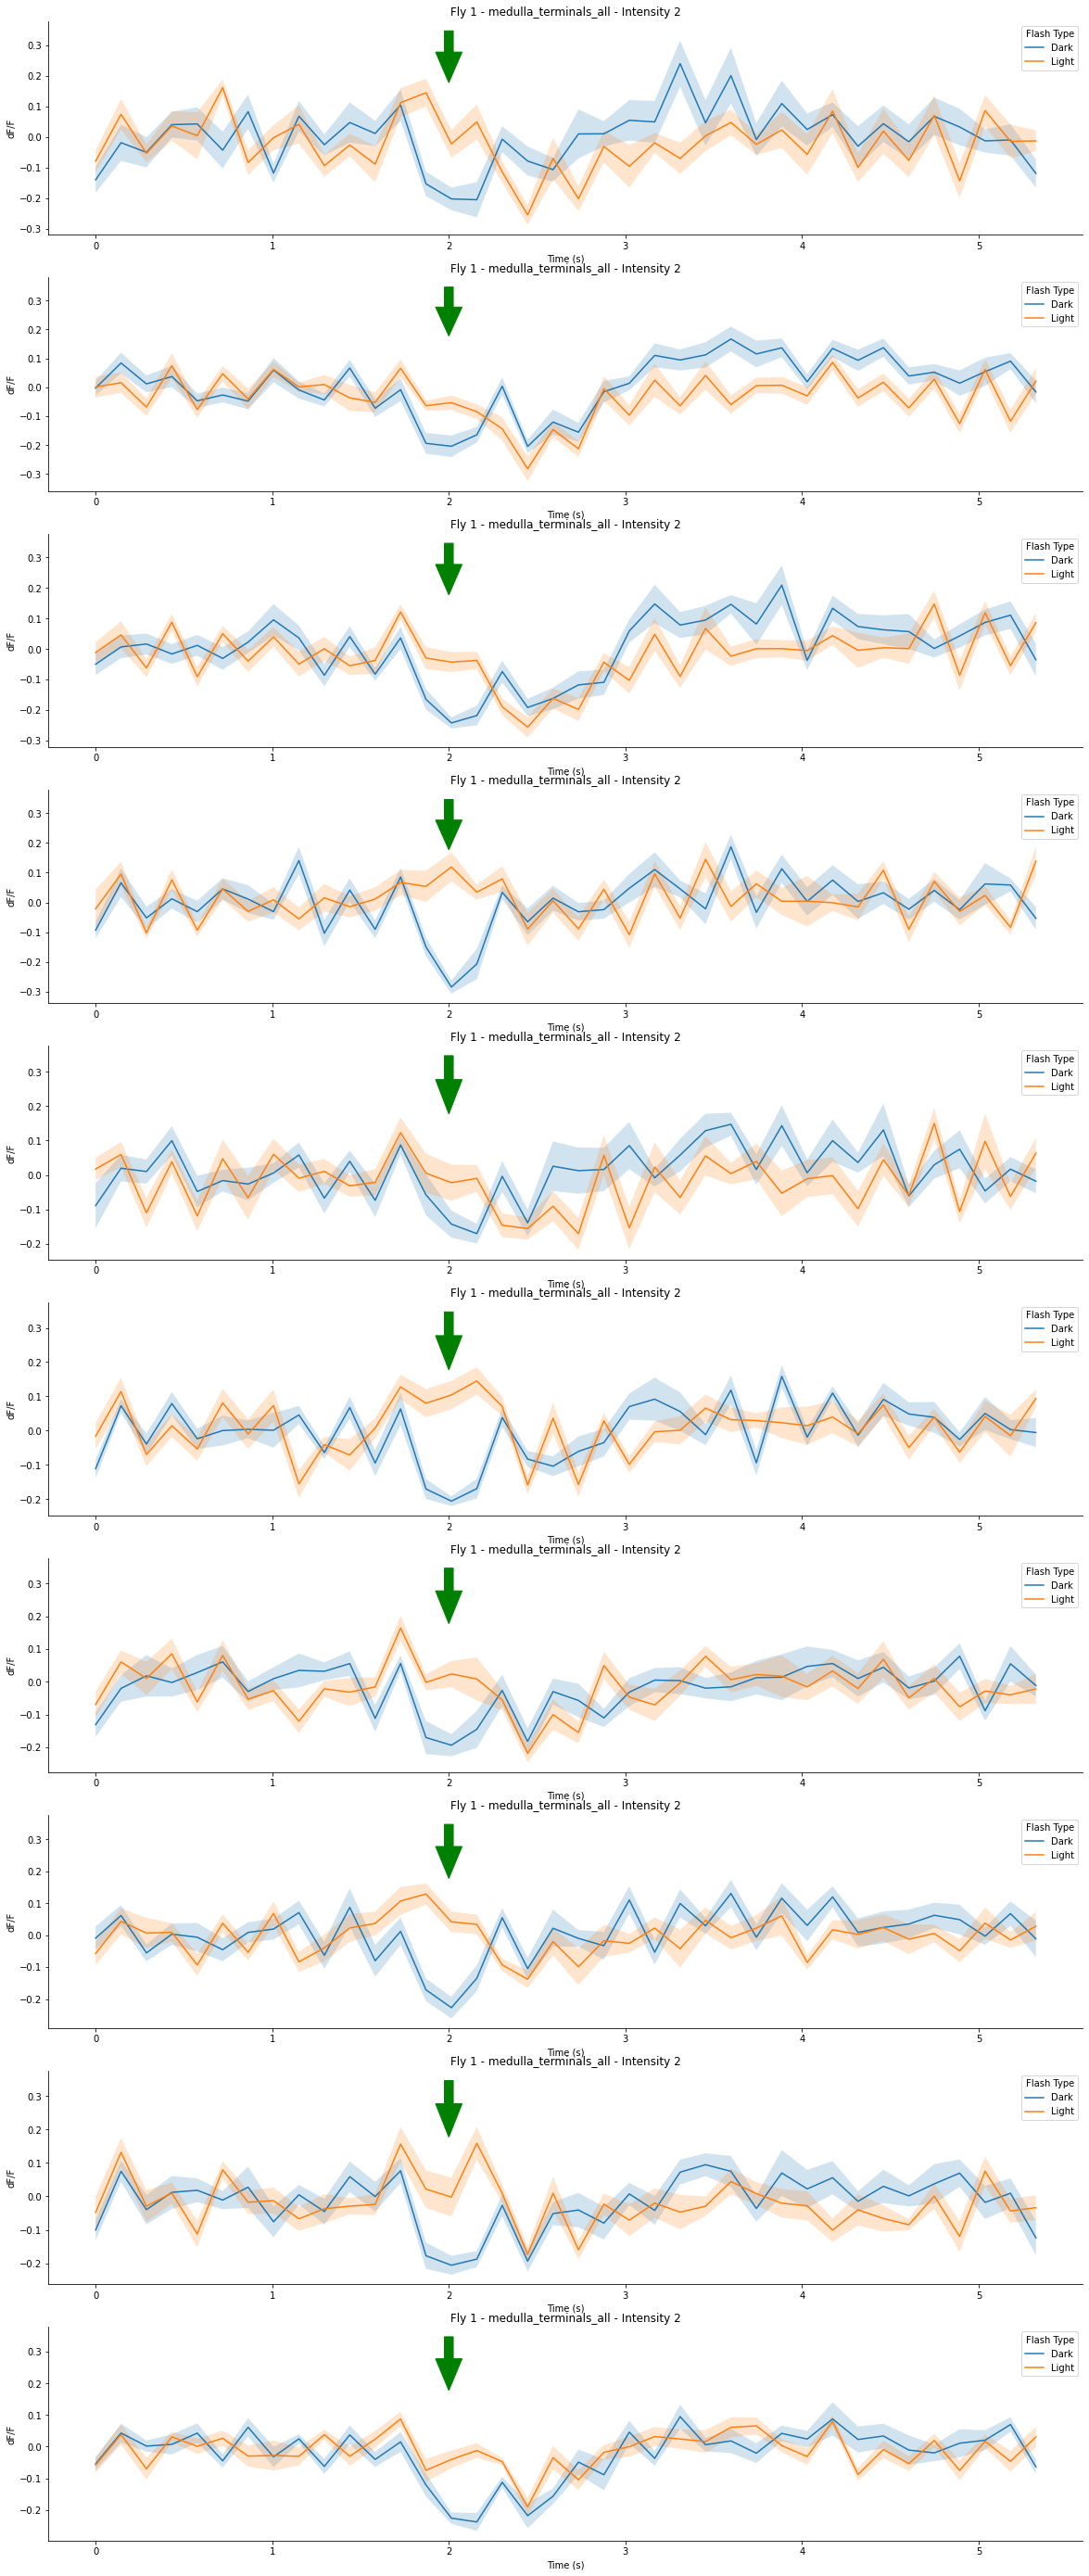

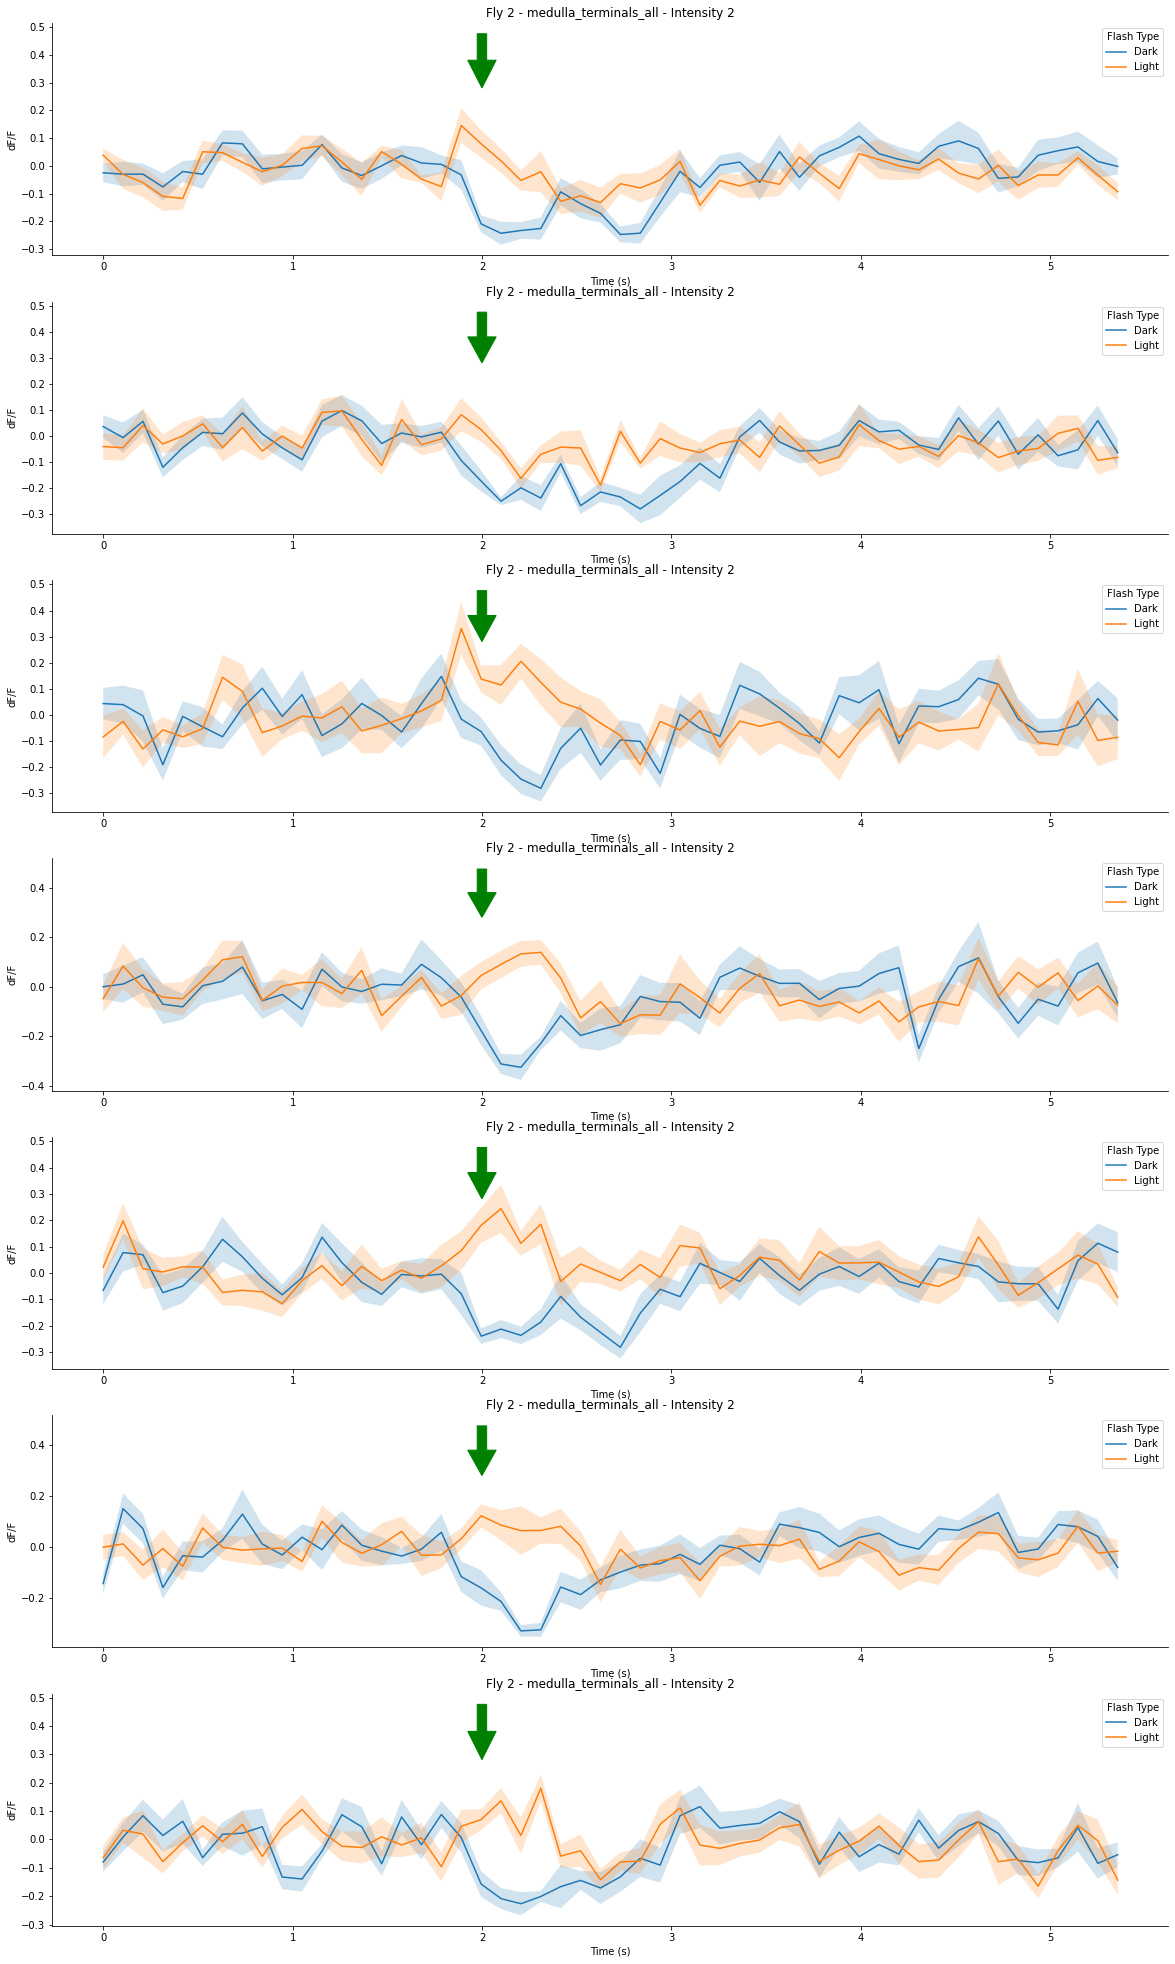

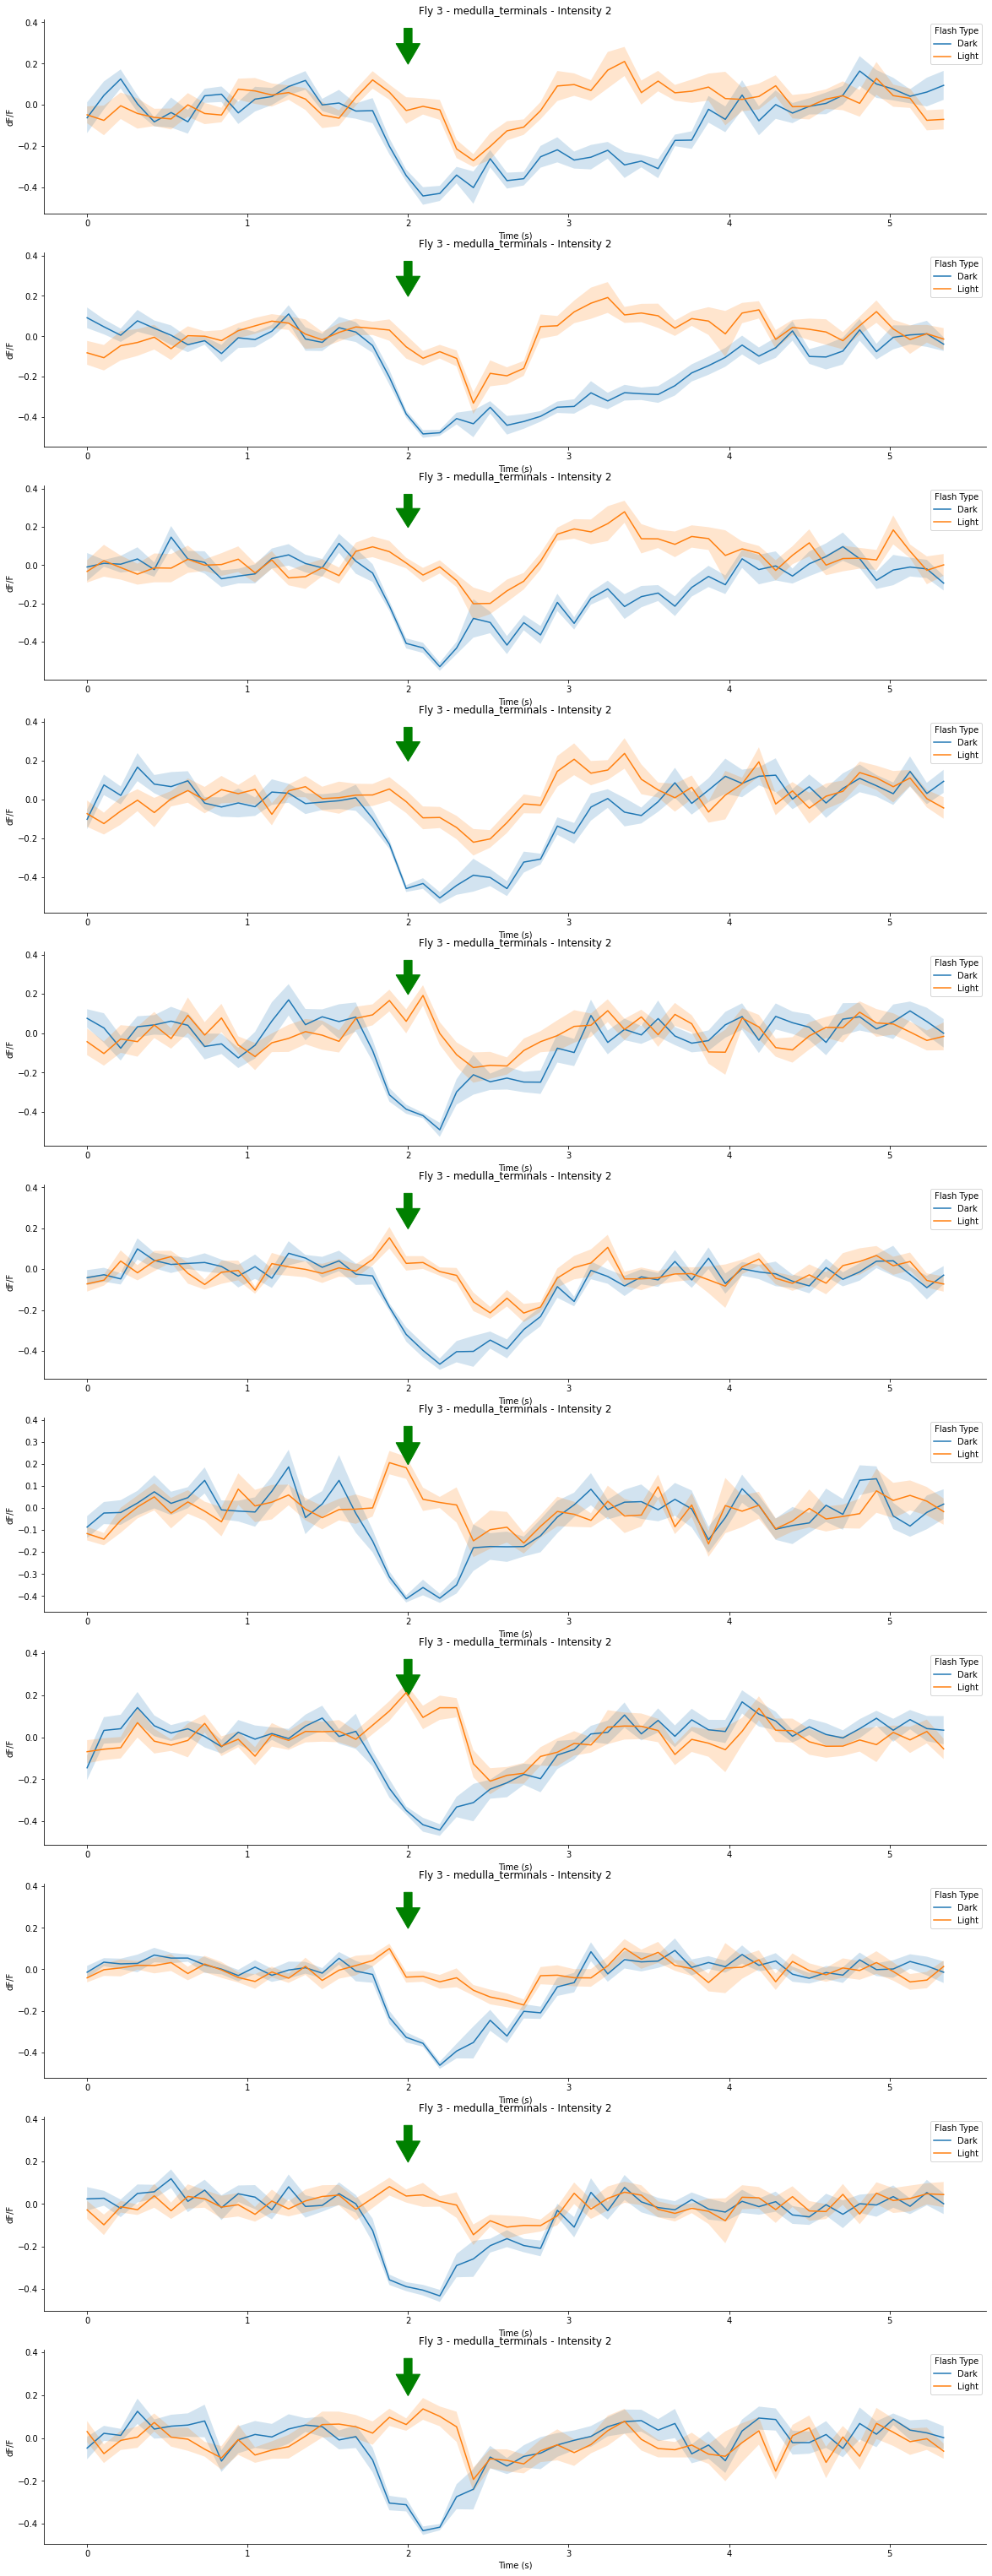

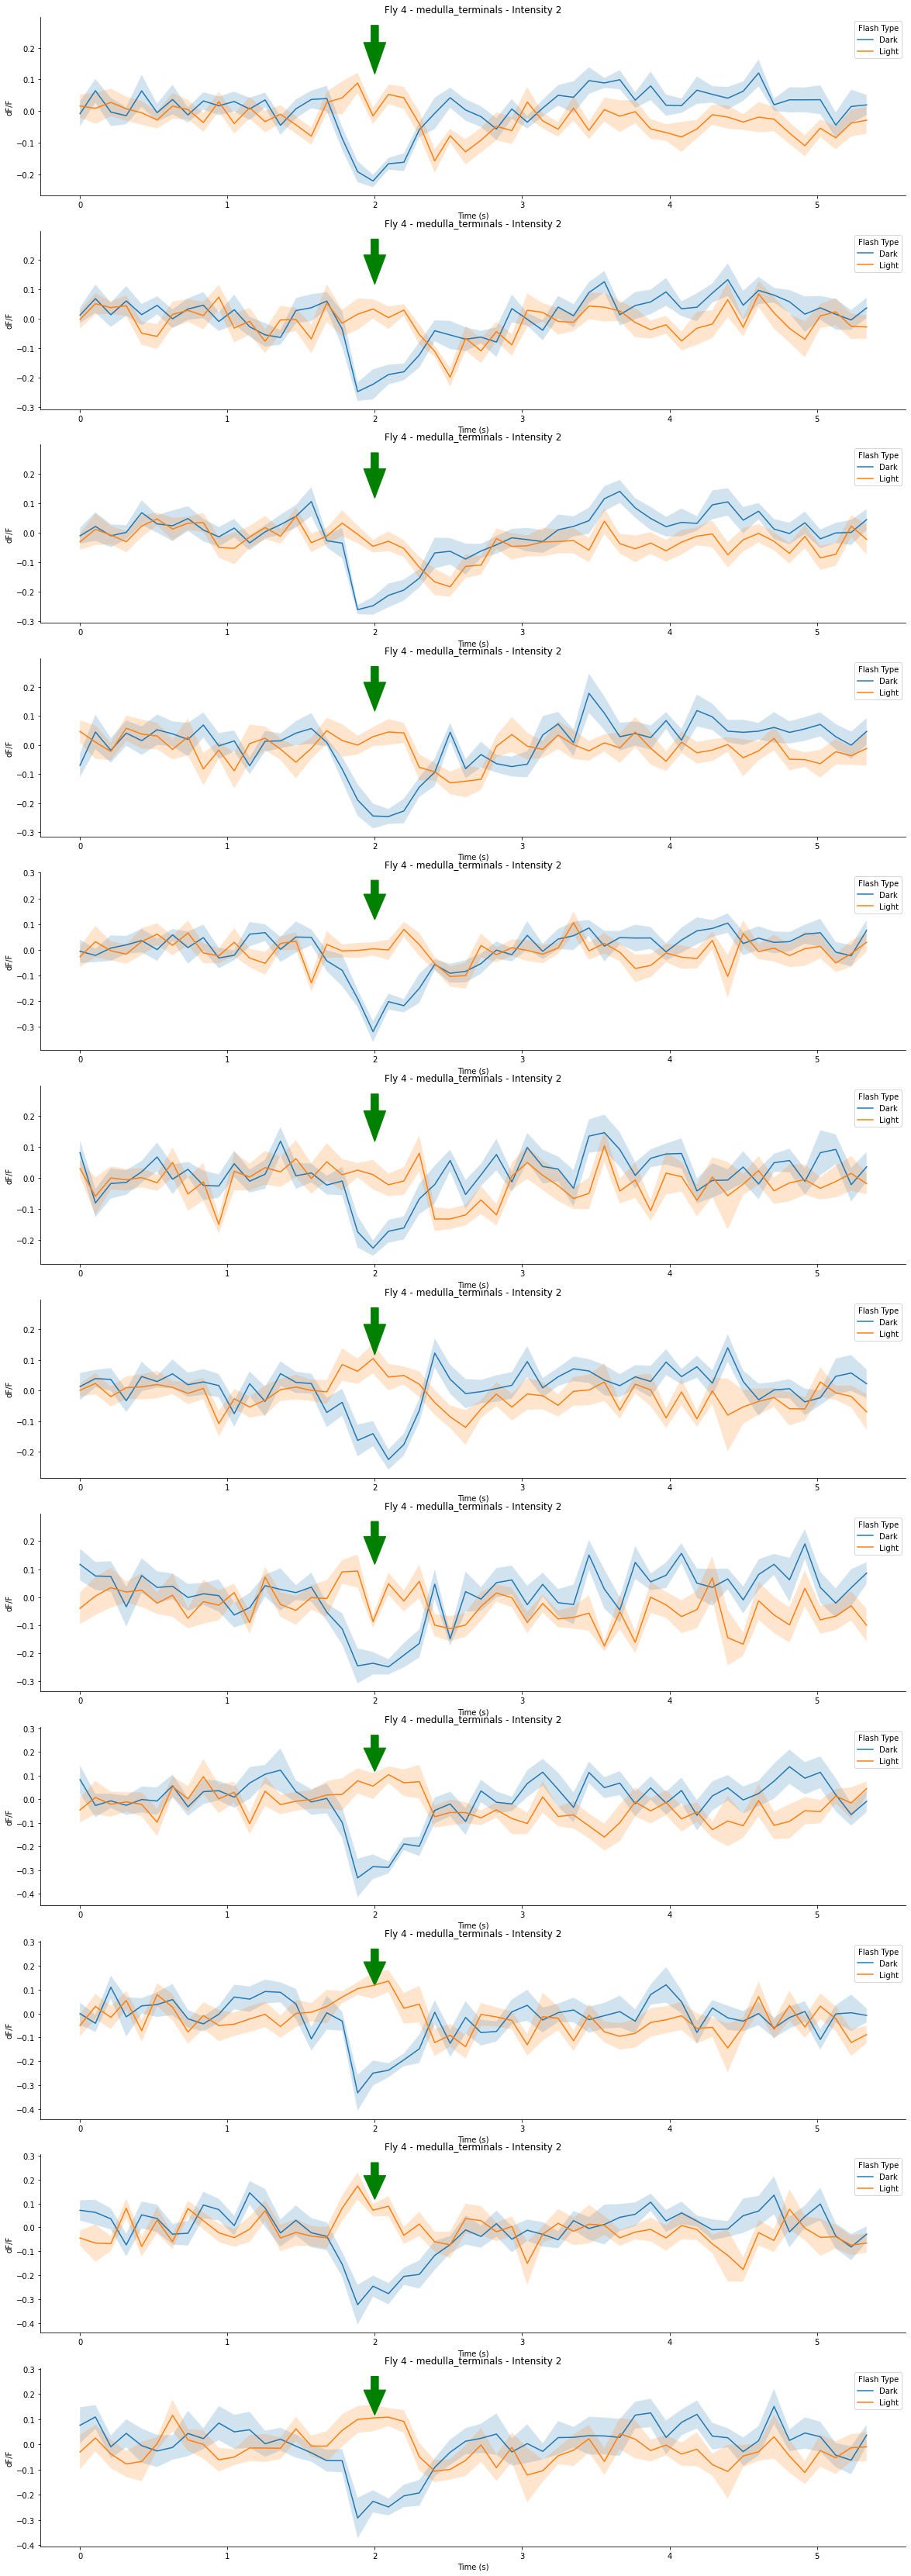

In [2]:
# Call function to get trial data for each fly
for fly_ind in range(len(asta_prox_all)):
    unique_parameter_values, mean_response, sem_response, trial_response_by_stimulus_intensity, time_vector = getTrialData(asta_prox_all[fly_ind])
    print(f'unique_parameter_values: {unique_parameter_values}')
    # calculate the min and max values for vis stim plotting
    min_val = np.min(mean_response-sem_response)*1.1
    max_val = np.max(mean_response+sem_response)*1.1


    fig, ax = plt.subplots(len(mean_response), 1, figsize=(20, 5*len(mean_response)))
    for roi_ind in range(len(mean_response)):
        # for each opto intensity
        for intensity_ind in range(len(unique_parameter_values)):
            # plot the mean response
            ax[roi_ind].plot(time_vector, mean_response[roi_ind][intensity_ind], label=flash_types[intensity_ind])
            # plot the SEM
            ax[roi_ind].fill_between(time_vector, mean_response[roi_ind][intensity_ind] - sem_response[roi_ind][intensity_ind], mean_response[roi_ind][intensity_ind] + sem_response[roi_ind][intensity_ind], alpha=0.2)
            
        # plot the vis flash
        ax[roi_ind].arrow(flash_start, max_val, 
                 0, max_val*-0.2, 
                 width=0.05,
                 head_length=0.1,
                 color='g',
                 )
            
        ax[roi_ind].set_title('Fly ' + str(asta_fly_list[fly_ind]) + ' - ' + str(asta_prox_all[fly_ind][3]) + ' - Intensity ' + str(intensity_ind+1))
        ax[roi_ind].set_xlabel('Time (s)')
        ax[roi_ind].set_ylabel('dF/F')
        ax[roi_ind].legend(title='Flash Type', loc='upper right')
        ax[roi_ind].spines['top'].set_visible(False)
        ax[roi_ind].spines['right'].set_visible(False)

## Plot averages across ROIs

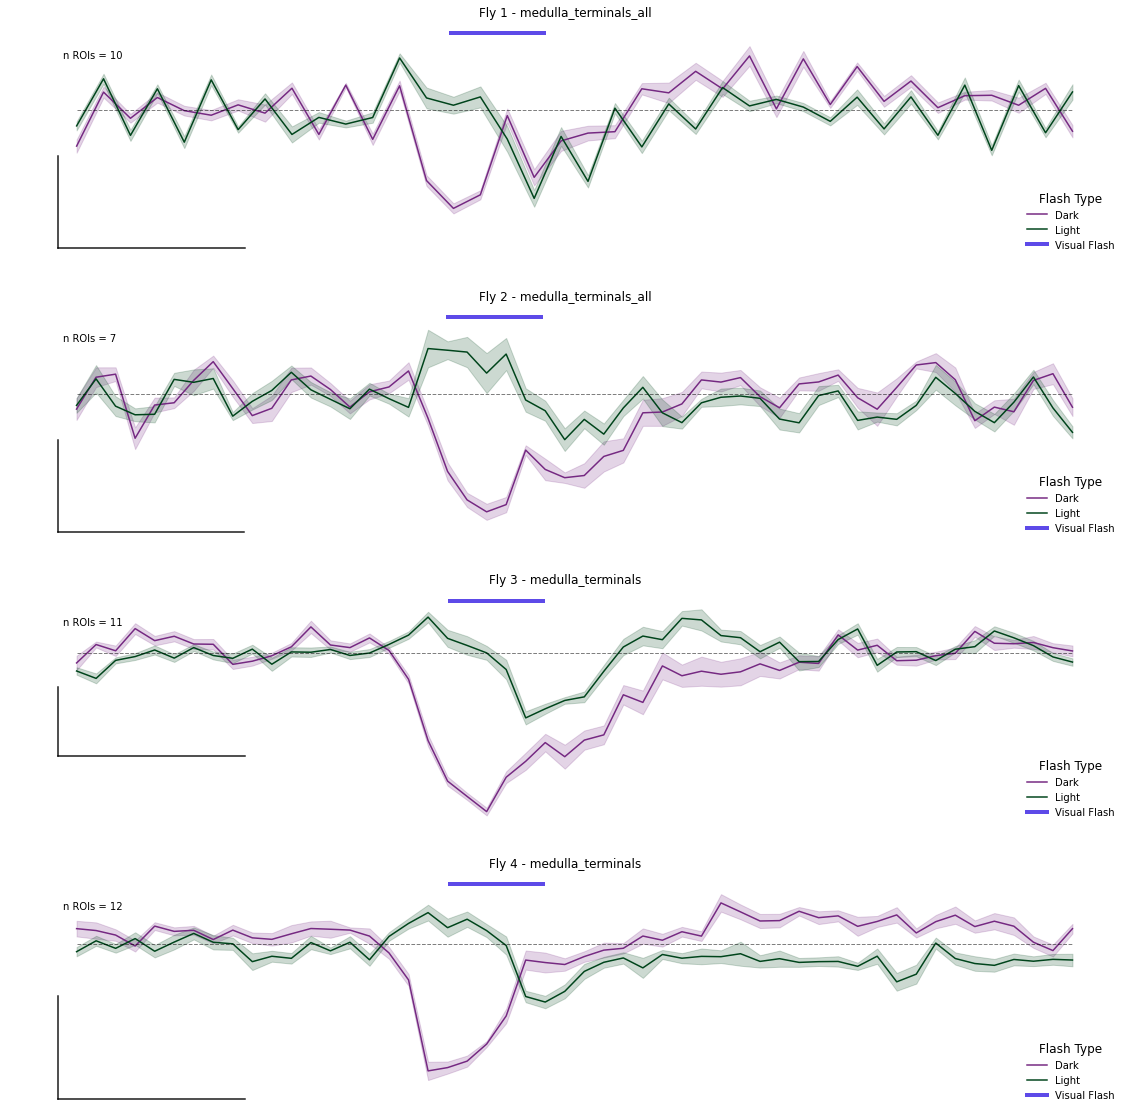

In [63]:
save_fig = True

# create subplots for each fly
cmap = plt.get_cmap('PRGn') # also 'cool' 'winter' 'PRGn' 'Pastel1' 'YlGnBu' 'twilight'
colors = [cmap(i) for i in np.linspace(0.1, 1.0, len(flash_types))]
fig, ax = plt.subplots(len(asta_prox_all), 1, figsize=(20, 5*len(asta_prox_all)))

for fly_ind in range(len(asta_prox_all)):
    unique_parameter_values, mean_response, sem_response, trial_response_by_stimulus_intensity, time_vector = getTrialData(asta_prox_all[fly_ind])
    
    # calculate mean across ROIs
    mean_response_cross_ROI = np.mean(mean_response, axis=0)
    # calculate SEM
    sem = np.std(mean_response, axis=0)/np.sqrt(len(mean_response))
    sem_plus = mean_response_cross_ROI + sem
    sem_minus = mean_response_cross_ROI - sem
    max_val = np.max(sem_plus)*1.2
    

    for intensity_ind in range(len(flash_types)):
        # plot the mean response
        ax[fly_ind].plot(time_vector, mean_response_cross_ROI[intensity_ind], label=flash_types[intensity_ind], color=colors[intensity_ind])
        # plot the SEM
        ax[fly_ind].fill_between(time_vector, sem_minus[intensity_ind], sem_plus[intensity_ind], alpha=0.2, color=colors[intensity_ind])

    # # plot the vis flash as an arrow
    # ax[fly_ind].arrow(flash_start, max_val, 
    #             0, max_val*-0.2, 
    #             width=0.03,
    #             head_length=0.03,
    #             color='g',
    #             )
    
    # plot a small line segment of length time_vector at dF/F = zero
    ax[fly_ind].plot([0, time_vector[-1]], [0, 0], color='k', linewidth=1, linestyle='--', alpha=0.5)

    # plot a line segment between the flash start and flash end
    flash_color = [i/255 for i in [93, 74, 232]]
    ax[fly_ind].plot([flash_start, flash_end], [max_val, max_val], color=flash_color, linewidth=4, label='Visual Flash')

    ax[fly_ind].text(0.05, 0.85, 'n ROIs = ' + str(mean_response.shape[0]), transform=ax[fly_ind].transAxes)
            
    ax[fly_ind].set_title('Fly ' + str(asta_fly_list[fly_ind]) + ' - ' + str(asta_prox_all[fly_ind][3]))
    ax[fly_ind].set_xlabel('Time (s)')
    ax[fly_ind].set_ylabel('dF/F')
    ax[fly_ind].legend(title='Flash Type', loc='lower right', framealpha=0, title_fontsize=12)
    ax[fly_ind].spines['top'].set_visible(False)
    ax[fly_ind].spines['right'].set_visible(False)

    plot_tools.cleanAxes(ax[fly_ind])
    plot_tools.addScaleBars(ax[fly_ind], dT=1, dF=0.2, T_value=-0.1, F_value=-0.3)

if save_fig:
    fig.savefig(save_directory+'AstA_neurons_each_fly_vis_response.svg', transparent=True, format='svg')
    fig.savefig(save_directory+'AstA_neurons_each_fly_vis_response.png', transparent=True, format='png', dpi=300, bbox_inches='tight')

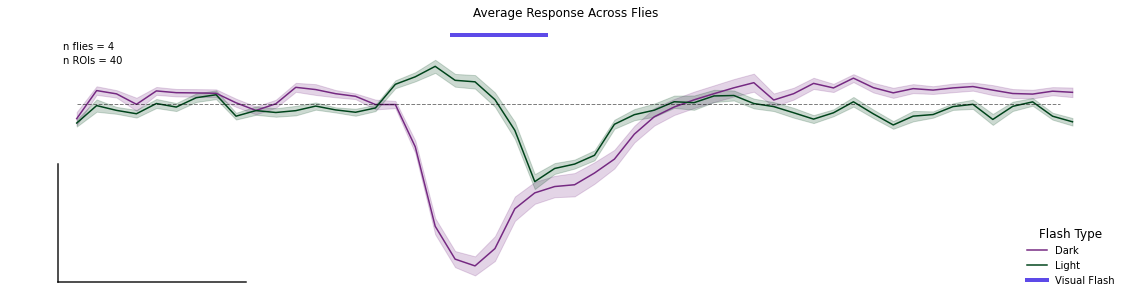

In [60]:
exp_list = asta_prox_all
fly_list = asta_fly_list
save_fig = True
# interpolation parameters
num_time_points = 51
stop_time = 5.3
time_vector_interp = np.linspace(0, stop_time, num_time_points)

# Find the average across all the flies and then plot them on a single plot
response_cross_fly = []

# First, find the mean_response for each fly and concatenate them
for fly_ind in range(len(exp_list)):
    unique_parameter_values, mean_response, _, _, time_vector = getTrialData(exp_list[fly_ind])
    
    # take only the time points that are less than stop_time seconds and find the index of the last time point
    time_vector = time_vector[time_vector <= stop_time]
    last_time_point_ind = np.where(time_vector == time_vector[-1])[0][0]
    # take the mean_response up to the last time point
    mean_response = mean_response[:, :, :last_time_point_ind+1]

    # interpolate the mean_response to have the same number of time points
    mean_response_interp = np.zeros([mean_response.shape[0], mean_response.shape[1], num_time_points])
    for intensity_ind in range(mean_response.shape[1]):
        for roi_ind in range(mean_response.shape[0]):
            mean_response_interp[roi_ind, intensity_ind, :] = np.interp(time_vector_interp, time_vector, mean_response[roi_ind, intensity_ind, :])

    # append the mean_response_interp to the response_cross_fly with np
    if len(response_cross_fly) == 0:
        response_cross_fly = mean_response_interp
    else:
        response_cross_fly = np.concatenate((response_cross_fly, mean_response_interp), axis=0)

# Calculate the mean and sem across all flies
cross_fly_mean = np.mean(response_cross_fly, axis=0)
cross_fly_sem = np.std(response_cross_fly, axis=0)/np.sqrt(response_cross_fly.shape[0])
cross_fly_sem_plus = cross_fly_mean + cross_fly_sem
cross_fly_sem_minus = cross_fly_mean - cross_fly_sem

fig, ax = plt.subplots(1, 1, figsize=(20, 5))

for intensity_ind in range(len(flash_types)):
    # plot the mean response
    ax.plot(time_vector_interp, cross_fly_mean[intensity_ind], label=flash_types[intensity_ind], color=colors[intensity_ind])
    # plot the SEM
    ax.fill_between(time_vector_interp, cross_fly_sem_minus[intensity_ind], cross_fly_sem_plus[intensity_ind], alpha=0.2, color=colors[intensity_ind])

# plot a small line segment of length time_vector at dF/F = zero
ax.plot([0, time_vector[-1]], [0, 0], color='k', linewidth=1, linestyle='--', alpha=0.5)
# plot a line segment between the flash start and flash end
flash_color = [i/255 for i in [93, 74, 232]]
ax.plot([flash_start, flash_end], [max_val, max_val], color=flash_color, linewidth=4, label='Visual Flash')
# Add text with the number of ROIs averaged and fly count on the plot
ax.text(0.05, 0.85, 'n ROIs = ' + str(response_cross_fly.shape[0]), transform=ax.transAxes)
ax.text(0.05, 0.9, 'n flies = ' + str(len(fly_list)), transform=ax.transAxes)

ax.set_title('Average Response Across Flies')
ax.set_xlabel('Time (s)')
ax.set_ylabel('dF/F')
# Plot the legend and make the box transparent and the title bold
ax.legend(title='Flash Type', loc='lower right', framealpha=0, title_fontsize=12)
# add scalebar from Max's visanalysis/visanalysis/util/plot_tools.py
plot_tools.cleanAxes(ax)
plot_tools.addScaleBars(ax, dT=1, dF=0.2, T_value=-0.1, F_value=-0.3)

if save_fig:
    fig.savefig(save_directory+'AstA_neurons_average_vis_response_across_flies.svg', transparent=True, format='svg')
    fig.savefig(save_directory+'AstA_neurons_average_vis_response_across_flies.png', transparent=True, format='png', dpi=300, bbox_inches='tight')
